In [4]:
import numpy as np
import pandas as pd
import mlflow
import warnings
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import sys
import os

In [5]:
# sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [10]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler


In [11]:
file_handler = FileHandler()
train_sales = pd.read_csv("../data/train.csv")

In [12]:
data = train_sales.groupby("Date").agg({"Sales": "mean"})
data

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570
...,...
2015-07-27,9602.952466
2015-07-28,8174.953363
2015-07-29,7623.284305


In [13]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(data)
data['DataScaled'] = scaled_array

In [14]:
data.describe()

,Sales,DataScaled
count,942.000000,9.420000e+02
mean,5782.702036,-1.185652e-16
std,2888.462029,1.000531e+00
min,87.284560,-1.972829e+00
25%,5321.408512,-1.597870e-01
50%,6036.153617,8.779282e-02
75%,7530.909865,6.055598e-01
max,14012.150673,2.850590e+00


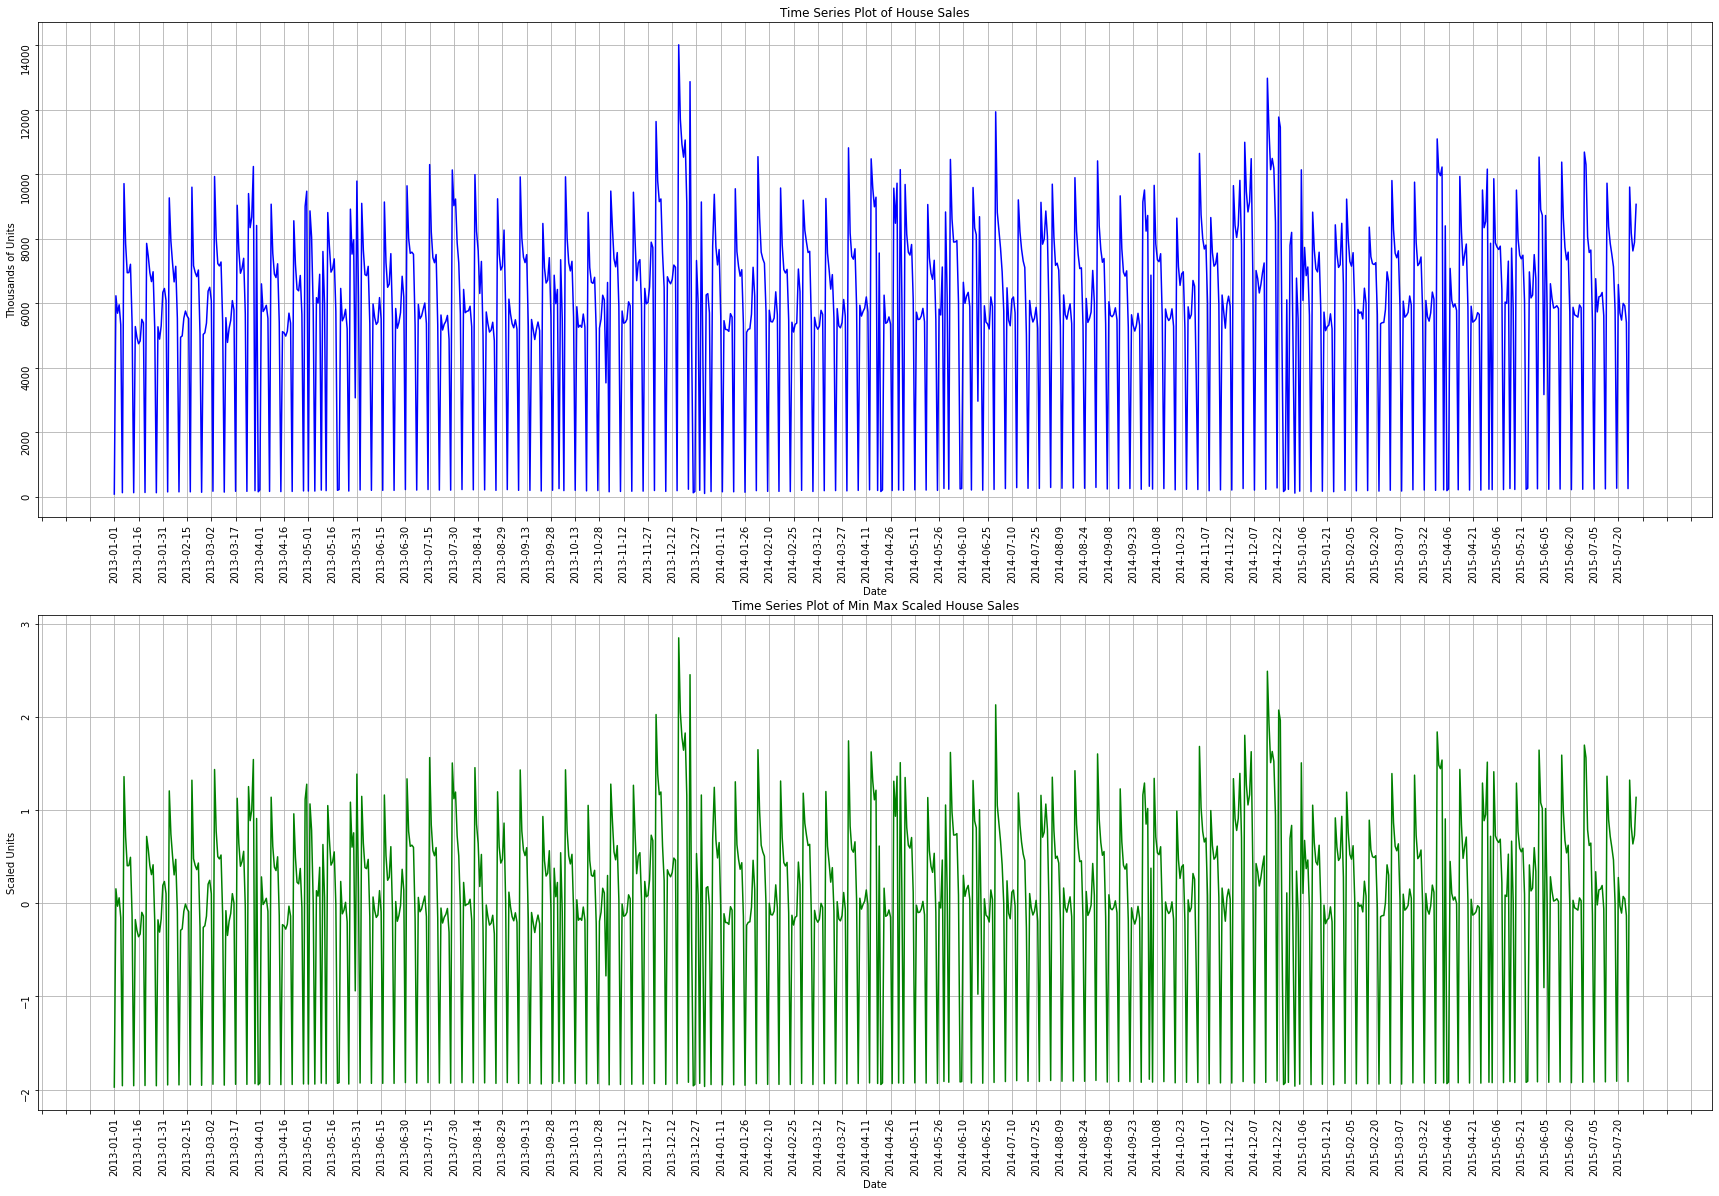

In [15]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(data.index, data.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(data.index, data.DataScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

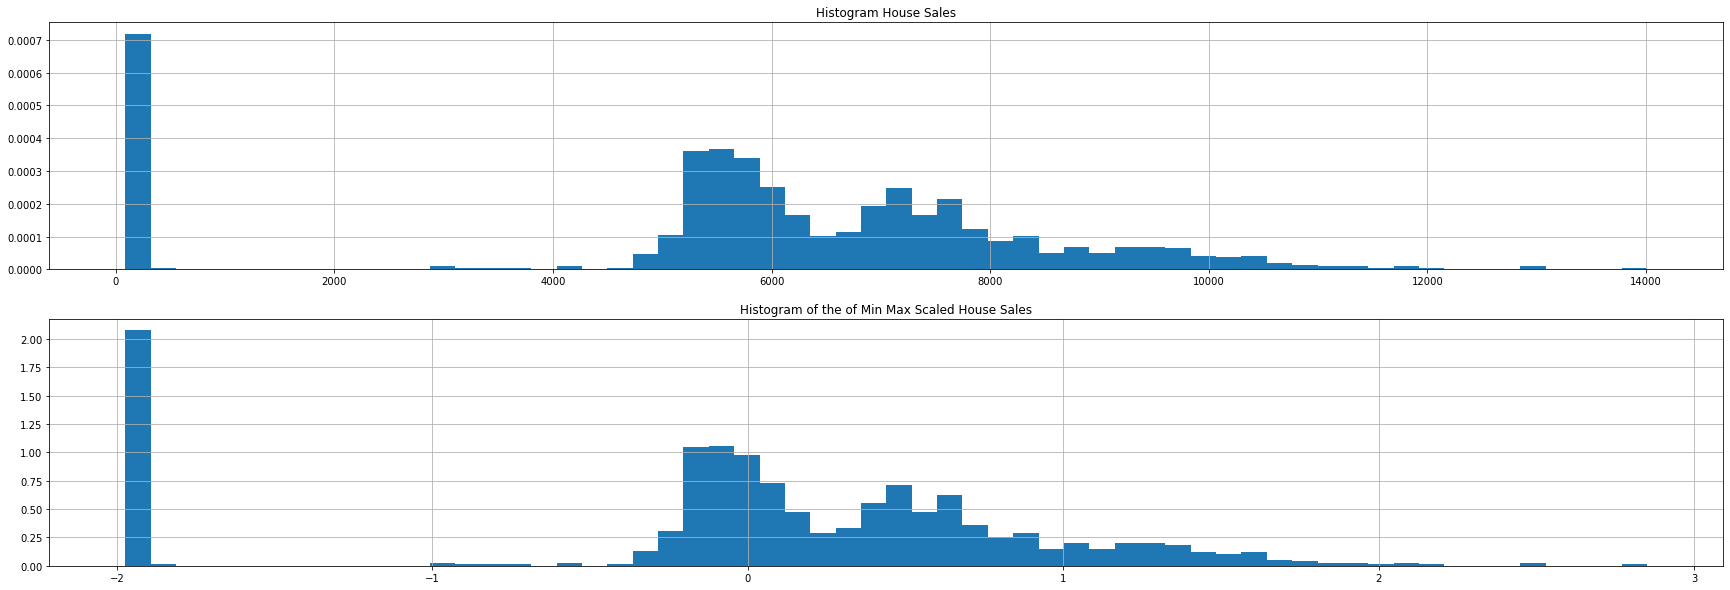

In [16]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(data.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(data.DataScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

### Unit Root Test

In [17]:
adfResult = adfuller(data.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.650822837207897
p-value: 9.870006549261963e-07


In [18]:
adfResult = adfuller(data.DataScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.650822837207894
p-value: 9.870006549262126e-07


### Removing Stationarity

In [24]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [25]:
dataDif = difference(data.DataScaled.values)

In [26]:
dataDif

0      2.128818
1     -0.187022
2      0.090444
3     -0.213537
4     -1.804232
         ...   
936    3.237549
937   -0.494643
938   -0.191092
939    0.092855
940    0.407244
Length: 941, dtype: float64

In [27]:
acfSalesScaled = acf(data.DataScaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [28]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

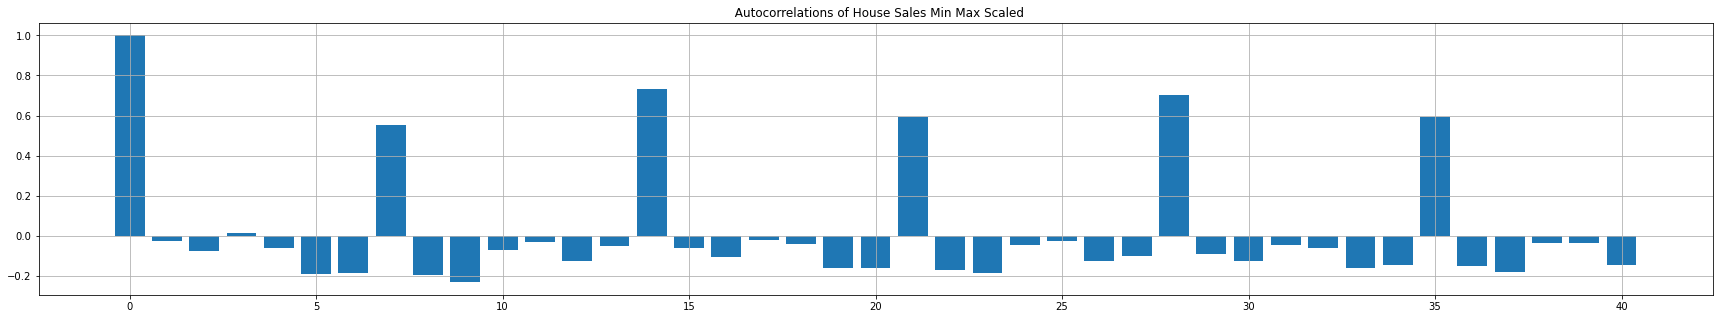

In [29]:
corrPlots(acfSalesScaledNp, '')

In [30]:
pacfSalesScaled = pacf(data.DataScaled.values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

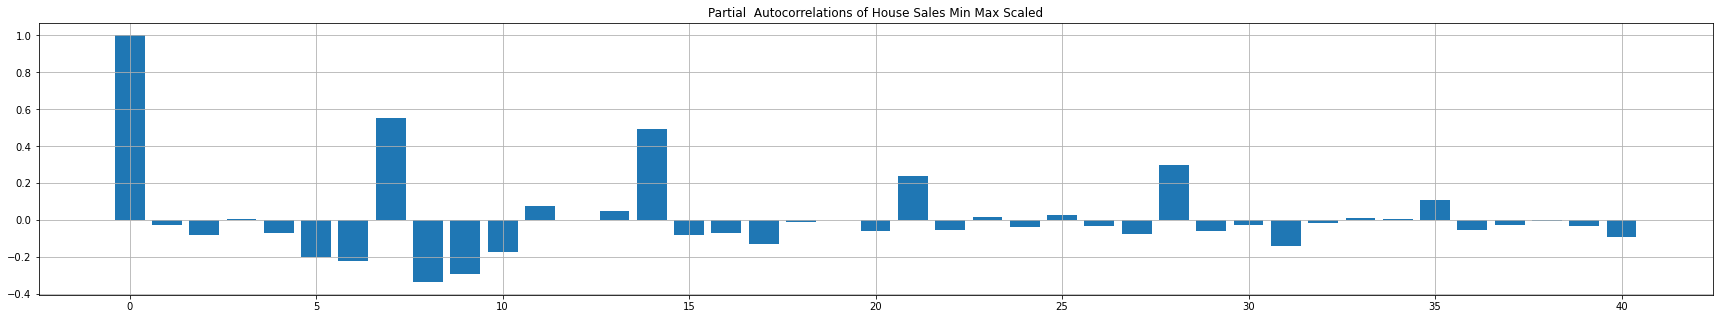

In [31]:
corrPlots(pacfSalesScaledNp, "Partial")

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM.

In [33]:
SIZE = len(data.DataScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [36]:
DateTrain = data.index.values[0:BATCH_SIZE]
DateValid = data.index.values[BATCH_SIZE:]
XTrain = data.DataScaled.values[0:BATCH_SIZE].astype('float32')
XValid = data.DataScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [37]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [38]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [39]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [40]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

[0, 1, 2, 3, 4]
[1, 2, 3, 4, 5]
[2, 3, 4, 5, 6]
[3, 4, 5, 6, 7]
[4, 5, 6, 7, 8]
[5, 6, 7, 8, 9]


In [41]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [42]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [43]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [44]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [45]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM.

In [46]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.4081 - val_loss: 0.3956
Epoch 2/200
1/1 [==============================] - 0s 131ms/step - loss: 0.4073 - val_loss: 0.3943
Epoch 3/200
1/1 [==============================] - 0s 155ms/step - loss: 0.4066 - val_loss: 0.3929
Epoch 4/200
1/1 [==============================] - 0s 136ms/step - loss: 0.4059 - val_loss: 0.3916
Epoch 5/200
1/1 [==============================] - 0s 131ms/step - loss: 0.4052 - val_loss: 0.3903
Epoch 6/200
1/1 [==============================] - 0s 139ms/step - loss: 0.4045 - val_loss: 0.3890
Epoch 7/200
1/1 [==============================] - 0s 147ms/step - loss: 0.4039 - val_loss: 0.3877
Epoch 8/200
1/1 [==============================] - 0s 150ms/step - loss: 0.4032 - val_loss: 0.3864
Epoch 9/200
1/1 [==============================] - 0s 153ms/step - loss: 0.4026 - val_loss: 0.3852
Epoch 10/200
1/1 [==============================] - 0s 139ms/step - loss: 0.4020 - val_loss: 0.3839
Epoch 11/200

1/1 [==============================] - 0s 147ms/step - loss: 0.3841 - val_loss: 0.3446
Epoch 84/200
1/1 [==============================] - 0s 151ms/step - loss: 0.3839 - val_loss: 0.3443
Epoch 85/200
1/1 [==============================] - 0s 148ms/step - loss: 0.3836 - val_loss: 0.3439
Epoch 86/200
1/1 [==============================] - 0s 150ms/step - loss: 0.3833 - val_loss: 0.3435
Epoch 87/200
1/1 [==============================] - 0s 157ms/step - loss: 0.3830 - val_loss: 0.3430
Epoch 88/200
1/1 [==============================] - 0s 169ms/step - loss: 0.3828 - val_loss: 0.3426
Epoch 89/200
1/1 [==============================] - 0s 155ms/step - loss: 0.3825 - val_loss: 0.3421
Epoch 90/200
1/1 [==============================] - 0s 165ms/step - loss: 0.3822 - val_loss: 0.3416
Epoch 91/200
1/1 [==============================] - 0s 143ms/step - loss: 0.3819 - val_loss: 0.3411
Epoch 92/200
1/1 [==============================] - 0s 131ms/step - loss: 0.3816 - val_loss: 0.3406
Epoch 93/200


1/1 [==============================] - 0s 139ms/step - loss: 0.3538 - val_loss: 0.2983
Epoch 165/200
1/1 [==============================] - 0s 134ms/step - loss: 0.3532 - val_loss: 0.2974
Epoch 166/200
1/1 [==============================] - 0s 121ms/step - loss: 0.3526 - val_loss: 0.2965
Epoch 167/200
1/1 [==============================] - 0s 133ms/step - loss: 0.3520 - val_loss: 0.2955
Epoch 168/200
1/1 [==============================] - 0s 141ms/step - loss: 0.3513 - val_loss: 0.2946
Epoch 169/200
1/1 [==============================] - 0s 148ms/step - loss: 0.3506 - val_loss: 0.2937
Epoch 170/200
1/1 [==============================] - 0s 142ms/step - loss: 0.3500 - val_loss: 0.2928
Epoch 171/200
1/1 [==============================] - 0s 150ms/step - loss: 0.3493 - val_loss: 0.2918
Epoch 172/200
1/1 [==============================] - 0s 145ms/step - loss: 0.3486 - val_loss: 0.2909
Epoch 173/200
1/1 [==============================] - 0s 148ms/step - loss: 0.3479 - val_loss: 0.2899
Epoc

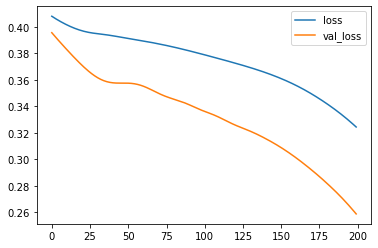

In [49]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

### Forecast the LSTM on the Validation Set and Assess Accuracy.

In [50]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [52]:
Forecast = model_forecast(model, data.DataScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

1/1 [==============================] - 1s 731ms/step


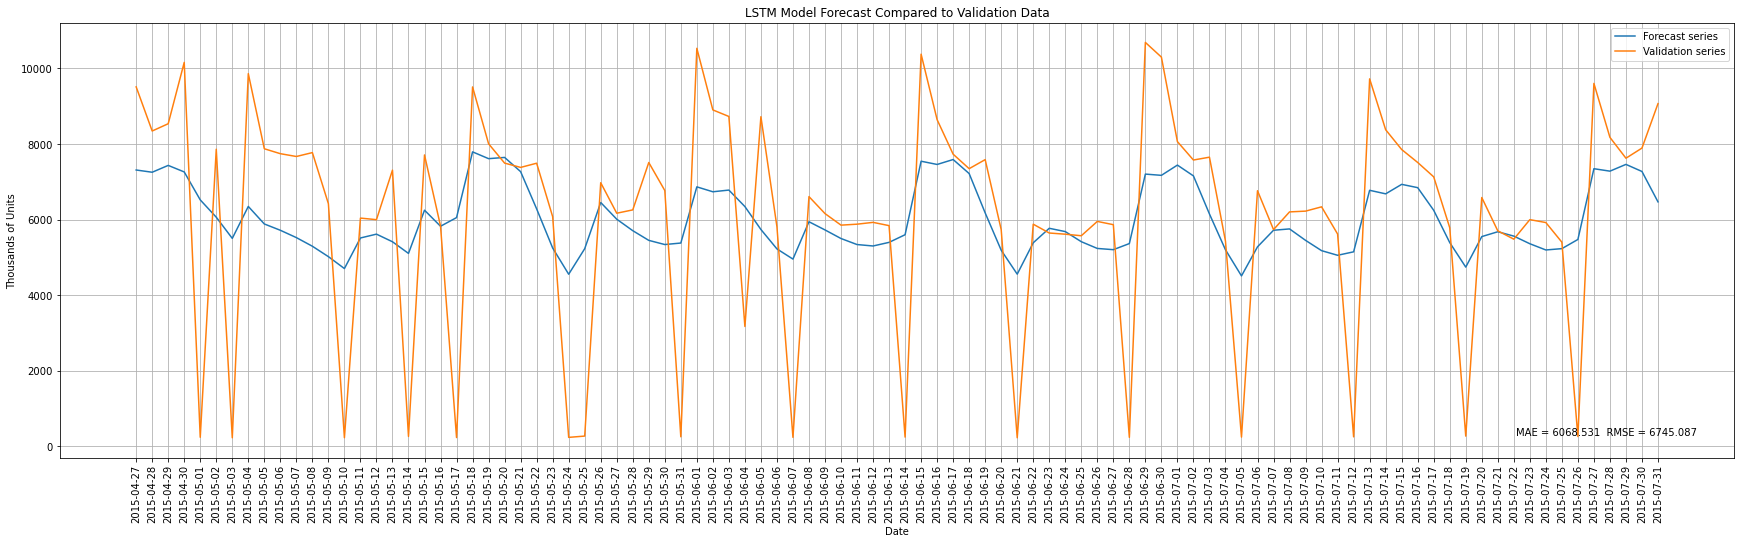

In [53]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [54]:
print(textstr)

MAE = 6068.531  RMSE = 6745.087
